In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig1_plots

import analysis_rnn as rnn
import analysis_neuro as spk
import basic_analysis as basic
import model_utils
import dim_alignment as dim
from task import generate_batch

from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig1_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

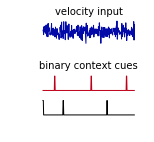

In [5]:
''' Figure 1E: inputs '''
f, gs = fig1_plots.plot_e(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

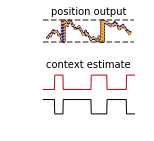

In [6]:
''' Figure 1F: outputs'''
f, gs = fig1_plots.plot_f(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard error of the mean:
position loss: 0.0105 +/- 0.000375
context loss: 0.00179 +/- 3.18e-05


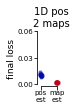

In [7]:
''' summary performance across models '''
f, ax = fig1_plots.plot_supp_1(data_folder, model_IDs)
ax.set_title('1D pos\n2 maps', fontsize=10, pad=5)
plt.show()

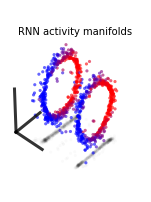

In [8]:
''' Figure 1H: aligned ring manifolds '''
f, ax = fig1_plots.plot_h(X, pos_targ)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

mean alignment = 0.6
sem misalignment = 0.0093


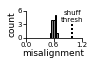

In [9]:
''' Figure 1I (or supp?): summary of ring alignment '''
f, ax = fig1_plots.plot_supp_2(data_folder, model_IDs)
f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
plt.show()

In [158]:
''' are the position outputs orthogonal? '''
n_models = len(model_IDs)

pos_out_angle = np.zeros(n_models)
for i, m_id in enumerate(model_IDs):
    # get the model weights
    model, _, _ = rnn.load_model_params(data_folder, model_ID)
    pos_out_w = model.readout_layer_pos.weight
    pos_out_w = pos_out_w.detach().numpy().T
    
    # angle between output weights
    pos_out_angle[i] = dim.cosine_sim(pos_out_w[:, 0], pos_out_w[:, 1])
    
avg_angle = np.rad2deg(np.arccos(np.abs(np.mean(pos_out_angle))))
print(f'the avg angle between position outputs is {int(avg_angle)} deg.')

the avg angle between position outputs is 88 deg.


In [123]:
'''
Another way to compute alignment:
let v = remapping vector
find each psi_p and take: norm(v - psi_p) / norm(v)
plot histogram
'''
from model_utils import sample_rnn_data, format_rnn_data
n_pos_bins = 50

n_models = len(model_IDs)
d_xi = np.zeros([n_models, n_pos_bins])
for i, m_id in enumerate(model_IDs):
    # get the rnn data
    inputs, outputs, targets = rnn.sample_rnn_data(data_folder, m_id)
    X, map_targ, pos_targ = format_rnn_data(outputs["hidden_states"],\
                                            targets["map_targets"],\
                                            targets["pos_targets"])
    
    # split by context
    X0 = X[map_targ==0]
    X1 = X[map_targ==1]
    pos0 = pos_targ[map_targ==0]
    pos1 = pos_targ[map_targ==1]

    # get the position-binned firing rates
    tc_0, _ = basic.tuning_curve_1d(X0, pos0, n_pos_bins=n_pos_bins)
    tc_1, _ = basic.tuning_curve_1d(X1, pos1, n_pos_bins=n_pos_bins)

    # find the remapping dimension
    v = rnn.remapping_dim(tc_0, tc_1)

    # find each psi_p
    xi_p = tc_0 - tc_1

    # get the difference
    d_xi[i] = np.linalg.norm(v - xi_p, axis=1) / np.linalg.norm(v)

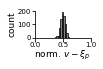

In [89]:
# font sizes
title_size = 10
axis_label = 9
tick_label = 7

# fig params 
f, ax = plt.subplots(1, 1, figsize=(1, 0.5))
BAR_LW = 0.7

ax.hist(d_xi.ravel(), np.linspace(0.0, 1.0, 40),\
        color="gray", lw=BAR_LW, edgecolor="k")
ax.set_xlabel("norm. $v - \\xi_p$", fontsize=axis_label, labelpad=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 1.0])
ax.set_xticks(np.arange(0, 1.1, 0.5))
ax.set_yticks([0, 100, 200])
ax.tick_params(which='major', labelsize=tick_label, pad=0.5)
ax.spines["left"].set_bounds(0, 200)
ax.set_ylabel("count", fontsize=axis_label, labelpad=1)

f.savefig(f'{save_folder}remap_vectors.png', dpi=600, bbox_inches='tight')
plt.show()

In [169]:
def relu(x):
    return x * (x > 0)

In [247]:
n_pos_bins = 50

d_xi_nonlinear = np.zeros([n_models, n_pos_bins])
for i, m_id in enumerate(model_IDs):
    # get the rnn data
    model, _, _ = rnn.load_model_params(data_folder, m_id)
    inputs, outputs, targets = rnn.sample_rnn_data(data_folder, m_id)
    X, map_targ, pos_targ = format_rnn_data(outputs["hidden_states"],\
                                            targets["map_targets"],\
                                            targets["pos_targets"])

    # split by context
    X0 = X[map_targ==0]
    X1 = X[map_targ==1]
    pos0 = pos_targ[map_targ==0]
    pos1 = pos_targ[map_targ==1]

    # get the position-binned firing rates
    tc_0, _ = basic.tuning_curve_1d(X0, pos0, n_pos_bins=n_pos_bins)
    tc_1, _ = basic.tuning_curve_1d(X1, pos1, n_pos_bins=n_pos_bins)

    # get context inputs
    ctxt_inp_w = model.linear_ih.weight[:, 1:]
    ctxt_inp_w = ctxt_inp_w.detach().numpy()
    
    # get the remapping dimension
    v = rnn.remapping_dim(tc_0, tc_1)

    # build the matrix of context influence on tc_0
    M_0 = relu(tc_0 - v)
    M_1 = relu(tc_1 + v)
#     M_0 = tc_0 - v
#     M_1 = tc_1 + v

    # get the difference
    d_0 = np.linalg.norm(M_0 - tc_1, axis=1) / np.linalg.norm(np.mean(tc_0 - tc_1, axis=0))
    d_1 = np.linalg.norm(M_1 - tc_0, axis=1) / np.linalg.norm(np.mean(tc_0 - tc_1, axis=0))
    d_xi_nonlinear[i] = np.mean(np.stack((d_0, d_1)), axis=0)

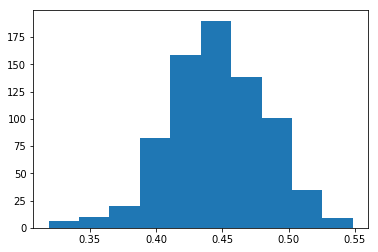

In [248]:
plt.hist(d_xi_nonlinear.ravel())
plt.show()

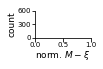

In [232]:
# font sizes
title_size = 10
axis_label = 9
tick_label = 7

# fig params 
f, ax = plt.subplots(1, 1, figsize=(1, 0.5))
BAR_LW = 0.7

ax.hist(d_xi_nonlinear.ravel(), np.linspace(0.0, 1.0, 30),\
        color="gray", lw=BAR_LW, edgecolor="k")
ax.set_xlabel("norm. $M - \\xi$", fontsize=axis_label, labelpad=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 1.0])
ax.set_xticks(np.arange(0, 1.1, 0.5))
ax.set_yticks([0, 300, 600])
ax.tick_params(which='major', labelsize=tick_label, pad=0.5)
ax.spines["left"].set_bounds(0, 600)
ax.set_ylabel("count", fontsize=axis_label, labelpad=1)

f.savefig(f'{save_folder}remap_vectors_nonlinear.png', dpi=600, bbox_inches='tight')
plt.show()

In [177]:
''' dimensionality of the remapping vectors '''
n_pos_bins = 250

# get the rnn data
inputs, outputs, targets = rnn.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = format_rnn_data(outputs["hidden_states"],\
                                        targets["map_targets"],\
                                        targets["pos_targets"])

# split by context
X0 = X[map_targ==0]
X1 = X[map_targ==1]
pos0 = pos_targ[map_targ==0]
pos1 = pos_targ[map_targ==1]

# get the position-binned firing rates
tc_0, _ = basic.tuning_curve_1d(X0, pos0, n_pos_bins=n_pos_bins)
tc_1, _ = basic.tuning_curve_1d(X1, pos1, n_pos_bins=n_pos_bins)

# find the remapping dimension
v = rnn.remapping_dim(tc_0, tc_1)

# find each psi_p
xi_p = tc_0 - tc_1

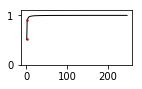

In [178]:
# PCA on remap vectors
pca = PCA().fit(xi_p)
var = pca.explained_variance_
total_var = np.sum(var)
pct_var = (var / total_var)
cum_var = np.cumsum(pct_var)

f, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.plot(np.arange(X.shape[1]) + 1, cum_var, c='k', lw=1, zorder=0)
ax.scatter(np.arange(2) + 1,
            cum_var[:2],
            facecolors='r', edgecolors='k',
            s=5, lw=0.2, zorder=1)
ax.set_ylim(0, 1.1)
plt.show()
f.savefig(f'{save_folder}xi_dims.png', dpi=600, bbox_inches='tight')

In [98]:
cum_var[:10]

array([0.48296238, 0.89994024, 0.92747181, 0.94782737, 0.96427082,
       0.97055235, 0.97600234, 0.97907984, 0.98132829, 0.98345295])

on average, 3 PCs explain 54.71% of the variance
on average, 12 PCs explain 90.07% of the variance


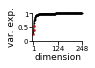

In [10]:
''' Figure 1J: summary of dimensionality '''
f, axes = fig1_plots.plot_j(data_folder, model_IDs,
                            top_num=3, top_num_1=2)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

630 total track traversals
59.0 total remapping events


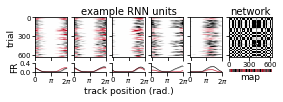

In [5]:
''' plot figure 1G: RNN single unit examples & network similarity '''
f, gs = fig1_plots.plot_g(data_folder, model_IDs[ex_id])
plt.show()
f.savefig(f'{save_folder}ex_tuning_similarity.png', dpi=600, bbox_inches='tight')

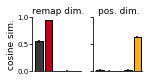

In [6]:
''' Figure 1K: alignment to remapping dim and position subspace '''
f, ax = fig1_plots.plot_k(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles.png', dpi=600, bbox_inches='tight')

In [ ]:
''' 
Remaining Qs:
- Are the position dims orthogonal?
    compute this for the pos outputs
- Find the vector v between each position bin across maps and show that they are equal
'''

In [13]:
''' Figure 2F: fixed points on ring manifolds 
this goes somewhere else
'''
# load the fixed points
fixed_pts_np = np.load(f"{base}/saved_models/{model_ID}/states_fixed_pt.npy")
fixed_pts = torch.from_numpy(fixed_pts_np)

# calculate the velocity at each fixed/slow point
num_batch = fixed_pts.shape[0]
num_maps = task_params["num_maps"]
inp_vel = torch.zeros(num_batch, 1)
inp_remaps = torch.zeros(num_batch, num_maps)

X1 = fixed_pts
X2 = model.one_step(fixed_pts, inp_vel, inp_remaps)
X1 = X1.detach().numpy()
X2 = X2.detach().numpy()

vels = np.asarray([])
for x1, x2 in zip(X1, X2): 
    vel = np.sum((x1 - x2)**2)
    vels = np.append(vels, vel)

NameError: name 'base' is not defined

In [ ]:
# filter out points where the velocity is too great
thresh = 0.005
sort_idx = np.argsort(vels)
f, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.scatter(np.arange(vels.shape[0]),
           vels[sort_idx[::-1]], 
           c='k', s=15,
           zorder=0)
xlims = ax.get_xlim()
ax.hlines(thresh, xlims[0], xlims[1],
          linestyles='dotted', colors='r',
          zorder=1, label='thresh'
         )

ax.set_xlim(xlims)
ax.set_ylim(-0.001, 0.02)
ax.set_ylabel('velocity')
ax.set_xlabel('fixed point')
ax.tick_params(which='major', labelsize=8, pad=1)
ax.legend()

plt.show()

In [ ]:
print(f'filtered out {np.sum(vels > thresh)} slow points with velocity > {thresh}')
fixed_pts = fixed_pts[vels < thresh]
fixed_pts_np = fixed_pts_np[vels < thresh]

In [ ]:
f, ax = fig_plots.plot_fig2f(X, fixed_pts, pos_targ)

ax.set_title('')

plt.show()
f.savefig(f'{save_folder}fixed_pts.png', dpi=600, bbox_inches='tight')